###### Module 3 Final Project Submission:

##### Student name: Omega Markos
##### Student pace: Part time
##### Scheduled project review date/time:10/15/19
##### Instructor name: Eli 
###### Video link: https://drive.google.com/open?id=1XyxS8VtbH8OUtZEvaLClxrBg8fDpKlLP

##### Import libraries

In [5]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
%matplotlib inline


##### Read & Explore data

In [6]:
# list the table names
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [259]:
# create a dataframe for each tables
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s) # this will give us a list name sql_comm with all the table names
#  slice each table in sql_comm & creat a data frame for each table
employees = pd.read_sql_query(sql_comm[0], conn)  
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)
suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

# Do discounts have a statistically significant effect on the     number of products customers order? If so, at what level(s) of discount?

To answer this question we need to explore the order detail table.

## Experimental Design

Sales discount is a great ways to increase revenue by attracting more customers and encourage them to buy more items.knowing the right way to give discount will help the company to increase revenue. we are trying to see if discount has an effect on the quantity of the orders and which discount has the highest effect. To analyze this we use the order_details table.

###### HO: The average quantity of product ordered is the same for orders with and without a discount.
###### HA:The average quantity of product ordered when a discount is given is higher or lower than for orders without a discount.

In [16]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


## Explanatory Data Analysis

In [26]:
order_details.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [24]:
order_details.isna().sum() # checking for missing values

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [27]:
order_details.describe() # descriptive analysis of the data

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


###### The cheapest item sold is 2 & the most expensive item is 263. the highest discount is 25% off

In [71]:
order_details.Discount.value_counts() # to see the level of discounts values

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [107]:
# create a new data frame showing the percentage by discount amount.
disc_given=order_details.groupby(order_details['Discount']).agg({'Id':'count'}).reset_index().rename(columns= {'Id':'Discounts','Discount':'Discount_amount'})


In [108]:
#calculate the percentage discount
disc_given['disc_per']= round((disc_given.Discounts/disc_given.Discounts.sum())*100,0)

In [109]:
disc_given

,Discount_amount,Discounts,disc_per
0,0.00,1317,61.0
1,0.01,1,0.0
2,0.02,2,0.0
3,0.03,3,0.0
4,0.04,1,0.0
5,0.05,185,9.0
6,0.06,1,0.0
7,0.10,173,8.0
8,0.15,157,7.0
9,0.20,161,7.0


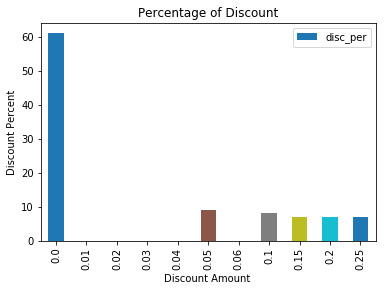

In [96]:
# plot the percentage discount
disc_given.plot(x='Discount_amount', y='disc_per',kind='bar')
plt.xlabel('Discount Amount ')
plt.ylabel('Discount Percent')
plt.title('Percentage of Discount')
plt.legend()
plt.show()

In [8]:
#create control and experimental groups
population = order_details['Quantity'] 
non_disc = order_details[order_details['Discount'] == 0]
non_disc = non_disc['Quantity']
disc = order_details[order_details['Discount'] != 0]
disc = disc['Quantity']


In [96]:
# finding the mean for the discounted & non discounted group
disc_ave=disc.mean()
print (f'The average quantity for discounted orders is {disc_ave }')
nondisc_ave=non_disc.mean()
print (f'The average quantity for non discounted orders is {nondisc_ave }')

The average quantity for discounted orders is 27.10978520286396
The average quantity for non discounted orders is 21.715261958997722


Text(0.5, 1.0, 'Discount v.s. No Discount Average Quantity of Product Per Order')

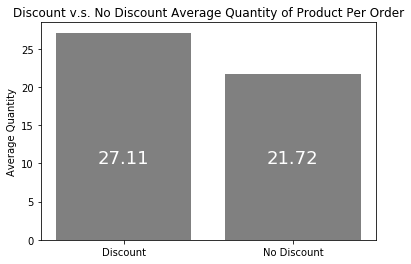

In [194]:
X = ['Discount', 'No Discount']
y = [disc.mean(),
     non_disc.mean()]
plt.bar(X,y, color=('grey'))
plt.text(s=round(y[1],2), x=1, y=10, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Quantity')
plt.title('Discount v.s. No Discount Average Quantity of Product Per Order')


Looking at the average of the two groups it looks like the discounted group have higher average order than the non discounted group. But to confirm that  this is not happening due to randomness we do the hypothesis test.

##  Checking for assumptions: Normality& Randomness


Before proceeding to our hypothesis test we need to check the three assumptions: The sample needs to be random and the distribution is normal. The size of the population is small enough to take the entire population. since we are not taking a sample, don't have the issue of sampling bias and sampling error. The next step is to check for normality.  


C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


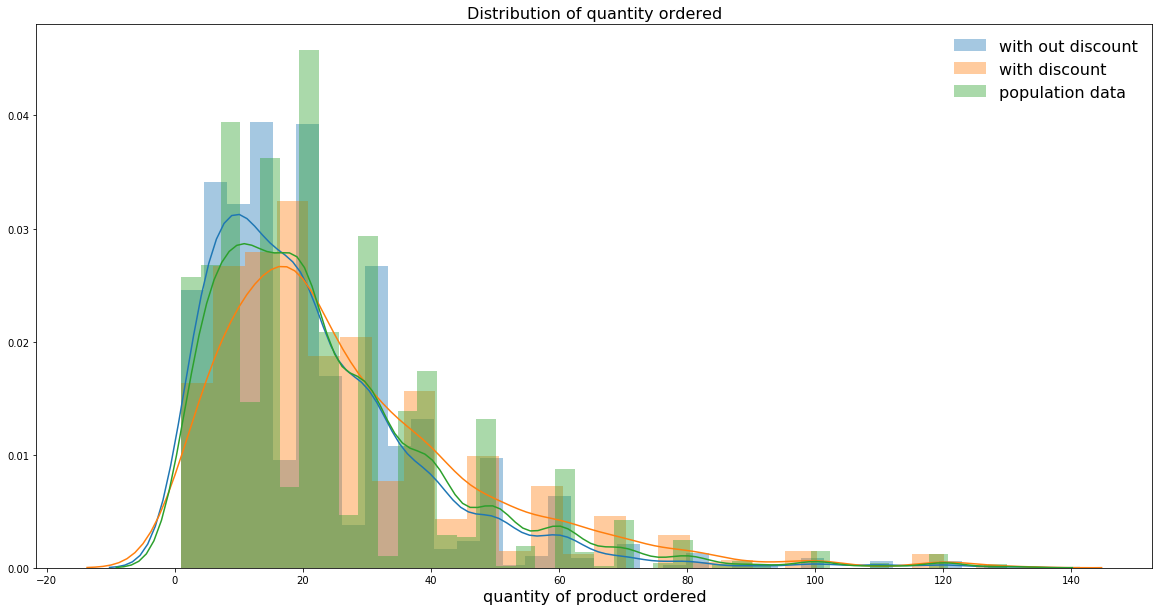

In [10]:
#plotting the two groups & the population to check for normality
plt.figure(figsize=(20, 10))
sns.distplot(non_disc, label='with out discount')
sns.distplot(disc, label='with discount')
sns.distplot(population, label='population data')
plt.title('Distribution of quantity ordered', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

The plot shows that all the distributions are skewed to the right and are not normal.But we can use the Shapiro normality check test to confirm that.

##### H0: Distribution is normal
##### HA: Distribution is not normal

In [19]:
stats.shapiro(disc) #to test if the discounted group distribution is normal

(0.8690301179885864, 6.88120409395894e-26)

In [20]:
population.mean()

23.812993039443157

In [21]:
population.std()

19.022046977493563

KS test is another test to check the for normality and it needs the info for population mean standard deviation. 

In [23]:
# using KS test to check for nornmality
stats.kstest(disc, 'norm', args=(23.81, 19)) 

KstestResult(statistic=0.1207327409135132, pvalue=4.2100545272205636e-11)

##### With a p value less that .05 we reject the null hypothesis and conclude that the  discounted group distribution is not normal. 

In [60]:
stats.shapiro(non_disc) # to test if the non discounted group is normal

(0.8434571027755737, 3.803856556577728e-34)

##### With a p value less that .05 we reject the null hypothesis and conclude that the   non discounted group distribution is not normal. 

In [69]:
stats.shapiro(population) # to test the population where the sample comes from is normal

(0.851548969745636, 5.022954345372307e-41)

##### With a p value less that .05 we reject the null hypothesis and conclude that the  distribution of population where the sample is coming from is not normal. 

In [98]:
len(disc)

838

In [99]:
len(non_disc)

1317

##  Choosing the right test statistics

Even though the the distributions broke the normality assumption since we have a large sample (>30) we can proceed and do T test.To decide which t test is appropriate we need to check the sample size & variance of the two groups. we can use the Levene test to check that.

##### H0: Discounted variance and non discount variance are the same.
##### HA: Discounted variance and non discount variance are not the same.

In [97]:
#Testing for equal variance between the discounted & non discounted group
stats.levene(disc, non_disc)

LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)

##### With low p value we reject the null hypothesis and conclude that the two groups have different variances. since the two groups have different sample sizes & variances Welch's t test the appropriate test.

In [62]:
# Welch's d test between discounted & non discounted group
stats.ttest_ind(non_disc, disc, equal_var=False)

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)

Another test  we can use is Monte Carlo test. This test doesn't require the normality assumption and it is the best choice when the data is not normal. 

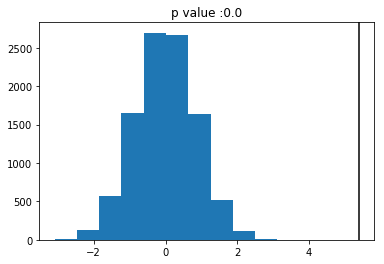

In [97]:

# monte carlo simulation to calculate p value
mean_diff = disc.mean()-non_disc.mean()
sample_diffs = []
counter = 0
for i in range(10000):
    sample1 = order_details.sample(replace=False, n=len(disc))
    sample2 = order_details.drop(sample1.index,axis=0)
    sample_diff = sample1['Quantity'].mean() - sample2['Quantity'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1
plt.hist(sample_diffs)
plt.axvline(mean_diff,color = 'k')
plt.title(f'p value :{np.round(counter/10000,3)}')
plt.show()
       

##### With low p value (<0.05) for both test types of tests(Monte Carlo & Welch's t test )we reject the null hypothesis and conclude that given discount has an effect on the quantity bought. To check how high the effect is we check the effect size by using Cohen's D test.

In [20]:
# create a function to calculate Cohen's D for any two given groups
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return d

In [103]:
round(abs(Cohen_d(non_disc, disc)), 1) # taking absolute value of Cohen's d and round is to 1 decimal point

0.3

##### We have a Cohen's D value of  0.3 which is to the lowest side of the effect size which indicates that the effect of the discount on the quantity sold is low. 

##### Checking which level of discount has effect

If there is an effect, is there a significant level of difference between the discounts or all the discounts have the same effect? to check this we need multiple comparison between the different discounts  & ANOVA test is the best choice.


 ##### H0: The average quantity of product ordered is the same for each discount level.
##### Ha: The average quantity of product ordered differs across the discount levels.

In [197]:
# since we have very few discounts with less than .1 we combine them toghether as one value .05
disc_data = order_details[order_details['Discount'] > 0]
disc_data['Discount'] = disc_data['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
disc_data['Discount'].value_counts()

C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

First let's see the plot of the average quantity ordered versus the different discounts. 

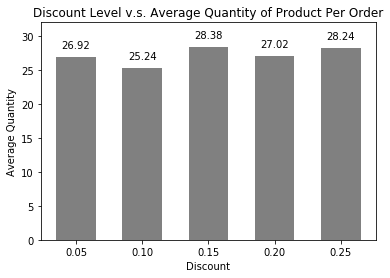

In [198]:
X = []
y = []
for i in disc_data['Discount'].unique():
    X.append(i)
    y.append(disc_data['Quantity'][disc_data['Discount'] == i].mean())
ax = plt.bar(X,y,width=.03, color=('grey'))
plt.ylim(0,32)
plt.ylabel('Average Quantity')
plt.xlabel('Discount')
plt.title('Discount Level v.s. Average Quantity of Product Per Order')
rects = ax.patches
y_round = []
for i in y:
    y_round.append(round(i,2))
labels = y_round
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')

From the plot , we see that there is no pattern between the different discounts but we have to check that if this is not happening due to randomness using ANOVA test.


In [117]:
# using anova test to see  quantity & discount
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,disc_data ).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(Discount),4.0,1065.701253,266.425313,0.616376,0.650947
Residual,833.0,360060.198508,432.245136,NaN,NaN


##### The p-value of our categorical 'Discount' variable is 0.651. Since this value is much higher than our alpha of 0.05, we fail to reject the null hypothesis. This suggests that the average quantities of product ordered across the discount levels are not significantly different.

## Conclusion

Exploring the data & running the appropriate tests we can conclude that giving a discount has a low effect on the average Quantity ordered but there is no significant difference among the different discount levels.

# Does discount has an effect on the quantity ordered across the regions?

##### H0: The effect of discount is the same across the regions.
##### Ha: The effect of discount is different across the regions.

In [27]:

orders_region = pd.read_sql_query('''

                        SELECT  Region, OrderId, ProductId, Discount , CustomerId, Quantity FROM OrderDetail OD
                        JOIN [Order] O
                        ON OD.OrderId = O.Id
                        JOIN [Customer] C
                        ON O.CustomerId = C.Id
                        
                        ''',conn)

In [16]:
orders_region.describe()

,OrderId,ProductId,Discount,Quantity
count,2078.000000,2078.000000,2078.000000,2078.000000
mean,10658.376323,40.903754,0.056035,23.924447
std,242.371015,22.153715,0.083421,19.151339
min,10248.000000,1.000000,0.000000,1.000000
25%,10449.000000,22.000000,0.000000,10.000000
50%,10656.000000,41.000000,0.000000,20.000000
75%,10861.000000,60.000000,0.100000,30.000000
max,11077.000000,77.000000,0.250000,130.000000


In [17]:
nondiscorder_reg = orders_region[orders_region['Discount'] == 0]
discorder_reg = orders_region[orders_region['Discount'] != 0]
#discorder_q = discorder_reg['Quantity']

In [39]:
discorder_reg.groupby('Region').mean()

,OrderId,ProductId,Discount,Quantity
Region,,,,
British Isles,10613.704918,38.393443,0.153279,31.327869
North America,10668.653179,39.786127,0.148786,30.849711
Northern Europe,10704.379310,42.482759,0.171552,25.189655
Scandinavia,10628.266667,36.400000,0.133333,18.466667
South America,10674.871795,39.239316,0.152137,19.948718
Southern Europe,10624.508475,42.644068,0.126271,17.745763
Western Europe,10644.848297,39.368421,0.136687,29.380805


In [47]:
nondiscorder_reg.groupby('Region').mean()

,OrderId,ProductId,Discount,Quantity
Region,,,,
British Isles,10650.093023,41.914729,0.0,19.496124
Central America,10584.090909,38.236364,0.0,12.109091
Eastern Europe,10789.937500,44.937500,0.0,12.812500
North America,10694.314961,40.299213,0.0,23.531496
Northern Europe,10618.188235,45.388235,0.0,22.870588
Scandinavia,10650.454545,37.545455,0.0,13.981818
South America,10666.363636,40.967914,0.0,21.524064
Southern Europe,10681.858974,41.769231,0.0,13.153846
Western Europe,10652.602906,42.694915,0.0,25.983051


In [41]:
# ANOVA test quantity vs regions 
formula = 'Quantity ~ C(Region)'
lm = ols(formula, discorder_reg).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F        PR(>F)
C(Region)   17678.580756    6.0  7.037177  2.587854e-07
Residual   334537.221974  799.0       NaN           NaN


##### With p value less than 0.05 we reject the null hypothesis and that means is discount has a significant effect on the quantities purchased across the different regions.          which region has higher effect? 

In [38]:
# list of regions
regionlist=orders_region.Region.unique()
regionlist

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [45]:
#calculating Cohen's D for each region
for i in regionlist:
    d=Cohen_d(nondiscorder_reg[nondiscorder_reg['Region'] ==i]['Quantity'], discorder_reg[discorder_reg['Region'] == i]['Quantity'])
    print (f'effect size for {i} is {round(abs(d),2)}' )

effect size for Western Europe is 0.16
effect size for South America is 0.11
effect size for Central America is nan
effect size for North America is 0.33
effect size for Northern Europe is 0.16
effect size for Scandinavia is 0.44
effect size for Southern Europe is 0.42
effect size for British Isles is 0.7
effect size for Eastern Europe is nan


Relatively,discount has the highest effect on the average quantity in the British Isles region.followed by Scandinavia and southern Europe. 

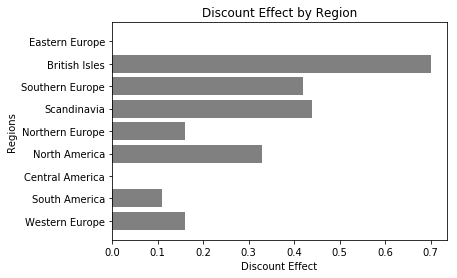

In [195]:
# plot d is  discount effect size by region :
d= [0.16,0.11,0,0.33,0.16,0.44,0.42,0.7,0]
region = ('Western Europe','South America','Central America','North America','Northern Europe','Scandinavia','Southern Europe','British Isles','Eastern Europe')
y_pos = np.arange(len(region))
# Create bars
plt.barh(y_pos, d, color=('grey'))
# Create names on the x-axis
plt.yticks(y_pos, region)
# Show graphic
plt.ylabel('Regions')
plt.xlabel('Discount Effect')
plt.title('Discount Effect by Region')
plt.show()


In [ ]:
nondiscorder_reg[nondiscorder_reg['Region'] =='Scandinavia']['Quantity']

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mod = MultiComparison(discorder_reg.Quantity, discorder_reg.Region)
print(mod.tukeyhsd())

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper  reject
----------------------------------------------------------------
 British Isles   North America  -0.4782  -9.4845   8.5282 False 
 British Isles  Northern Europe -6.1382  -17.2306  4.9541 False 
 British Isles    Scandinavia   -12.8612 -30.2923  4.5699 False 
 British Isles   South America  -11.3792 -20.9309 -1.8274  True 
 British Isles  Southern Europe -13.5821 -24.6262 -2.5381  True 
 British Isles   Western Europe -1.9471  -10.3907  6.4965 False 
 North America  Northern Europe -5.6601  -14.837   3.5169 False 
 North America    Scandinavia   -12.383  -28.6625  3.8964 False 
 North America   South America  -10.901  -18.1405 -3.6614  True 
 North America  Southern Europe -13.1039 -22.2225 -3.9854  True 
 North America   Western Europe -1.4689  -7.1672   4.2294 False 
Northern Europe   Scandinavia    -6.723  -24.2428 10.7969 False 
Northern Europe  South Am

##### Conclusion : Discount has significantly low effect in South America & Southern Europe.

# Do late deliveries affect Customer's ordering?

In [222]:
# cur.execute("""SELECT *
#               FROM [order];
#               """)
# orders = pd.DataFrame(cur.fetchall())
# orders.columns = [i[0] for i in cur.description]
# orders.head()

In [223]:
# order_details.head()

In [224]:
query = """
SELECT
   o.Id,
   o.CustomerId,
   o.OrderDate,
   o.RequiredDate,
   o.ShippedDate,
   o.ShipVia,
   od.OrderId,
   od.ProductId,
   SUM(od.UnitPrice) as UnitPrice,
   SUM(od.Quantity) as Quantity,
   SUM(od.Discount) as Discount,
   SUM(od.UnitPrice * od.Quantity * (1-od.Discount))as OrderTotal
FROM
   [Order] o
   JOIN
   [OrderDetail] od
WHERE o.Id = od.OrderId
GROUP BY od.OrderId
"""
ordersl = pd.read_sql_query(query, conn)

In [229]:
ordersl.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,leship
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,10248,72,58.6,27,0.0,440.00,-16 days
1,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,10249,51,61.0,49,0.0,1863.40,-37 days
2,10250,HANAR,2012-07-08,2012-08-05,2012-07-12,2,10250,65,66.9,60,0.3,1552.60,-24 days
3,10251,VICTE,2012-07-08,2012-08-05,2012-07-15,1,10251,65,49.2,41,0.1,654.06,-21 days
4,10252,SUPRD,2012-07-09,2012-08-06,2012-07-11,2,10252,60,94.0,105,0.1,3597.90,-26 days


In [230]:
ordersl.isna().sum() #checking for missing value

Id              0
CustomerId      0
OrderDate       0
RequiredDate    0
ShippedDate     0
ShipVia         0
OrderId         0
ProductId       0
UnitPrice       0
Quantity        0
Discount        0
OrderTotal      0
leship          0
dtype: int64

In [226]:
ordersl.dropna(inplace=True) # drop missing value

In [287]:
#create late shipping by subtracting shipping date from required date
ordersl['leship']= pd.to_datetime(ordersl['ShippedDate'])-pd.to_datetime(ordersl['RequiredDate']) 
ordersl.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,leship,Late,OrderYear
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,10248,72,58.6,27,0.0,440.00,-16 days,no,2012
1,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,10249,51,61.0,49,0.0,1863.40,-37 days,no,2012
2,10250,HANAR,2012-07-08,2012-08-05,2012-07-12,2,10250,65,66.9,60,0.3,1552.60,-24 days,no,2012
3,10251,VICTE,2012-07-08,2012-08-05,2012-07-15,1,10251,65,49.2,41,0.1,654.06,-21 days,no,2012
4,10252,SUPRD,2012-07-09,2012-08-06,2012-07-11,2,10252,60,94.0,105,0.1,3597.90,-26 days,no,2012


In [285]:
# had_late = ordersl.loc[ordersl['leship'].dt.days > 0].CustomerId.unique()
# had_late

In [288]:
# to change the column to numbers of days (to change it from date format to number format)
ordersl['leship']= ordersl.leship.dt.days

In [236]:
# late column-if it is shipped after the required date(>0) it is late 
ordersl['Late']=['yes' if x > 0 else 'no' for x in ordersl['leship'] ]

In [237]:
ordersl.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,leship,Late
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,10248,72,58.6,27,0.0,440.00,-16,no
1,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,10249,51,61.0,49,0.0,1863.40,-37,no
2,10250,HANAR,2012-07-08,2012-08-05,2012-07-12,2,10250,65,66.9,60,0.3,1552.60,-24,no
3,10251,VICTE,2012-07-08,2012-08-05,2012-07-15,1,10251,65,49.2,41,0.1,654.06,-21,no
4,10252,SUPRD,2012-07-09,2012-08-06,2012-07-11,2,10252,60,94.0,105,0.1,3597.90,-26,no


In [219]:
#ordersl['HadLate']= ordersl.CustomerId.isin(had_late)

In [242]:
early_orders =ordersl.loc[ordersl.Late=='no']['OrderTotal']
late_orders=ordersl.loc[ordersl.Late=='yes']['OrderTotal']

In [244]:
late_orders.mean()

1798.259864864865

In [245]:
early_orders.mean()

1519.8445518134715

In [251]:
late_delivery_percent = len(late_orders)/len(ordersl)*100
late_delivery_percent

4.573547589616811

## Checking for Normality

##### H0: Distribution is normal
##### HA: Distribution is not normal

In [128]:
stats.shapiro(early_orders)

(0.5080080032348633, 2.129973665773722e-43)

In [129]:
stats.shapiro(late_orders)

(0.4361311197280884, 0.0)

##### with p value less than .05 we reject the null & conclude that the distribution is not normal

## Checking for equal variance

##### H0: Early and late delivery groups have the same variances.
##### HA: Early and late delivery groups have different variances.

In [246]:
stats.levene(late_orders, early_orders)

LeveneResult(statistic=0.6872218692043743, pvalue=0.4073560584432159)

##### with p value greater than .05 we fail to reject the null. The two groups have equal variances.

C:\Users\Omega\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


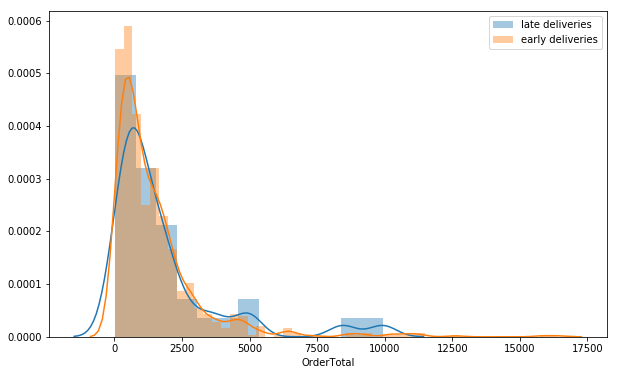

In [253]:
plt.figure(figsize=(10,6))
sns.distplot(late_orders,label='late deliveries')
sns.distplot(early_orders,label='early deliveries')
plt.legend()
plt.show()

In [254]:
# we use t test because of equal variance
stats.ttest_ind(early_orders,late_orders,equal_var=True)


Ttest_indResult(statistic=-0.8921001454084001, pvalue=0.37260517618360034)

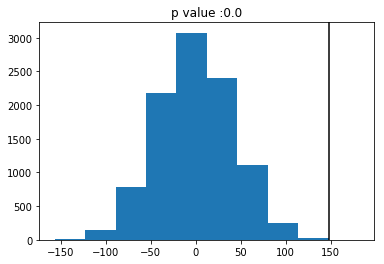

In [138]:
# monte carlo simulation to calculate p value
mean_diff = early_orders.mean()-late_orders.mean()
sample_diffs = []
counter = 0
for i in range(10000):
    sample1 = ordersj.sample(replace=False, n=len(disc))
    sample2 = ordersj.drop(sample1.index,axis=0)
    sample_diff = sample1['OrderValue'].mean() - sample2['OrderValue'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1
plt.hist(sample_diffs)
plt.axvline(mean_diff,color = 'k')
plt.title(f'p value :{np.round(counter/10000,3)}')
plt.show()

According to Monte Carlo test with p value less than .05 we reject the null. *this contradicts with the t test result*

Text(0.5, 1.0, 'Early v.s. Late Average Total Order')

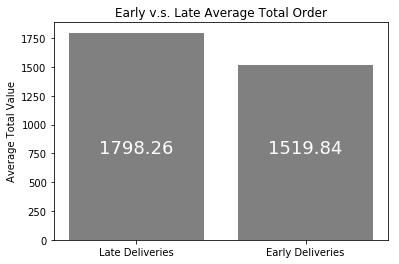

In [258]:
X = ['Late Deliveries', 'Early Deliveries']
y = [late_orders.mean(),
     early_orders.mean()]
plt.bar(X,y, color=('grey'))
plt.text(s=round(y[1],2), x=1, y=750, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=750, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Total Value')
plt.title('Early v.s. Late Average Total Order')


 ##### With  p value greater than 0.05 , we fail to reject the null hypothesis & conclude that  late deliveries has no effect on total value of order. * we have to consider looking at the customers total value after they have late delivery *

# Is there a statistically significant difference in performance of shipping companies?


In [177]:
ordersl.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,ProcessingTime
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,10248,72,58.6,27,0.0,440.00,12.0
1,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,10249,51,61.0,49,0.0,1863.40,5.0
2,10250,HANAR,2012-07-08,2012-08-05,2012-07-12,2,10250,65,66.9,60,0.3,1552.60,4.0
3,10251,VICTE,2012-07-08,2012-08-05,2012-07-15,1,10251,65,49.2,41,0.1,654.06,7.0
4,10252,SUPRD,2012-07-09,2012-08-06,2012-07-11,2,10252,60,94.0,105,0.1,3597.90,2.0


In [185]:
ordersl.isna().sum()

Id                 0
CustomerId         0
OrderDate          0
RequiredDate       0
ShippedDate       21
ShipVia            0
OrderId            0
ProductId          0
UnitPrice          0
Quantity           0
Discount           0
OrderTotal         0
ProcessingTime    21
dtype: int64

In [186]:
ordersl.dropna(inplace=True)

In [187]:
ordersl['ProcessingTime']= pd.to_datetime(ordersl['ShippedDate'])-pd.to_datetime(ordersl['OrderDate'])
ordersl.ProcessingTime = ordersl.ProcessingTime.dt.days
ordersl.head()

,Id,CustomerId,OrderDate,RequiredDate,ShippedDate,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,ProcessingTime
0,10248,VINET,2012-07-04,2012-08-01,2012-07-16,3,10248,72,58.6,27,0.0,440.00,12
1,10249,TOMSP,2012-07-05,2012-08-16,2012-07-10,1,10249,51,61.0,49,0.0,1863.40,5
2,10250,HANAR,2012-07-08,2012-08-05,2012-07-12,2,10250,65,66.9,60,0.3,1552.60,4
3,10251,VICTE,2012-07-08,2012-08-05,2012-07-15,1,10251,65,49.2,41,0.1,654.06,7
4,10252,SUPRD,2012-07-09,2012-08-06,2012-07-11,2,10252,60,94.0,105,0.1,3597.90,2


In [277]:
ordersl['OrderDate'] =pd.to_datetime(ordersl['OrderDate'])
ordersl['OrderYear']= ordersl.OrderDate.dt.year

In [278]:

ordersl.groupby('OrderYear').mean()

,Id,ShipVia,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,leship
OrderYear,,,,,,,,,
2012,10323.500000,2.131579,10323.500000,57.625000,61.909211,63.032895,0.141447,1368.973487,-19.618421
2013,10603.500000,1.973039,10603.500000,55.825980,67.684020,62.473039,0.153922,1512.463734,-18.987745
2014,10932.763052,1.979920,10932.763052,54.128514,71.874859,60.437751,0.130924,1665.407371,-19.787149


In [188]:
ordersl.groupby('ShipVia').mean()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,OrderTotal,ProcessingTime
ShipVia,,,,,,,,
1,10661.106122,10661.106122,56.987755,63.857102,64.204082,0.157347,1413.187929,8.571429
2,10661.326984,10661.326984,54.326984,72.696762,60.936508,0.141905,1639.936503,9.234921
3,10632.004016,10632.004016,55.979920,65.773695,61.020080,0.135141,1514.235213,7.473896


Looking the average values it shows that there is a difference in average processing time. To check this that this is not happening by chance we will do multiple comparison using ANOVA.

In [189]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, ordersl).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    433.501581    2.0  4.676819  0.009563
Residual    37354.696194  806.0       NaN       NaN


##### with p value less than .05 we reject the null. There is a significant difference in processing time between the shipping companies. 

### Which shipping company has the lowest processing time?

In [190]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mod = MultiComparison(ordersl.ProcessingTime, ordersl.ShipVia)
print(mod.tukeyhsd())


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.6635  -0.6982  2.0252 False 
  1      3    -1.0975   -2.536  0.3409 False 
  2      3     -1.761  -3.1165 -0.4055  True 
---------------------------------------------


In [260]:
shippers.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


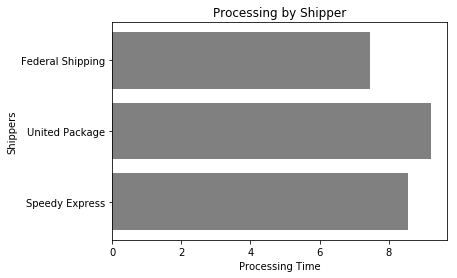

In [262]:
p_time = [8.57,9.24,7.47]
shipper = ('Speedy Express','United Package','Federal Shipping')
y_pos = np.arange(len(shipper))
# Create bars
plt.barh(y_pos, p_time, color=('grey'))
# Create names on the x-axis
plt.yticks(y_pos, shipper)
# Show graphic
plt.ylabel('Shippers')
plt.xlabel('Processing Time')
plt.title('Processing Time by Shipper')
plt.show()

##### Federal Shipping has significantly law procesing time. United package has higher processing time.

# Does training have an effect on employee performance?

To analyze this, we need more info from  the employee table Notes column

In [74]:
# to increase the display width so that I can see the employee info.
pd.options.display.max_colwidth = 400
print(employees.Notes)


0                                                                                                                                                                                                                                    Education includes a BA in psychology from Colorado State University in 1970.  She also completed 'The Art of the Cold Call.'  Nancy is a member of Toastmasters International.
1    Andrew received his BTS commercial in 1974 and a Ph.D. in international marketing from the University of Dallas in 1981.  He is fluent in French and Italian and reads German.  He joined the company as a sales representative, was promoted to sales manager in January 1992 and to vice president of sales in March 1993.  Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of ...
2                                                                                                                                                                    Janet has a BS degree in 

In [65]:
# joining the employee & Order table.
emp_invoices = pd.read_sql('''SELECT  o.EmployeeId,od.UnitPrice ,od.Discount,od.Quantity
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Employee e ON o.EmployeeId = e.Id
                           
                    
                    ''', conn)
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity
0,5,14.0,0.0,12
1,5,9.8,0.0,10
2,5,34.8,0.0,5
3,6,18.6,0.0,9
4,6,42.4,0.0,40


In [66]:
emp_invoices['totalinv']= emp_invoices.UnitPrice * (1 - emp_invoices.Discount) * emp_invoices.Quantity

In [67]:
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity,totalinv
0,5,14.0,0.0,12,168.0
1,5,9.8,0.0,10,98.0
2,5,34.8,0.0,5,174.0
3,6,18.6,0.0,9,167.4
4,6,42.4,0.0,40,1696.0


In [68]:
emp_invoices['trained']= 1

In [292]:
nottrained=[1,4,8,9]
for x in nottrained: 
    emp_invoices.loc[emp_invoices.EmployeeId==x,['trained']]=0

In [70]:
 emp_invoices['bilingual']=0

In [71]:
bi=[2,6,8,9]
for x in bi: 
    emp_invoices.loc[emp_invoices.EmployeeId==x,['bilingual']]=1

In [72]:
emp_invoices.head()

,EmployeeId,UnitPrice,Discount,Quantity,totalinv,trained,bilingual
0,5,14.0,0.0,12,168.0,1,0
1,5,9.8,0.0,10,98.0,1,0
2,5,34.8,0.0,5,174.0,1,0
3,6,18.6,0.0,9,167.4,1,1
4,6,42.4,0.0,40,1696.0,1,1


In [74]:
trained_emp= emp_invoices[emp_invoices.trained==1]
trained_emp=trained_emp['totalinv']
nontrained_emp =emp_invoices[emp_invoices.trained==0]
nontrained_emp=nontrained_emp['totalinv']

In [264]:
nontrained_emp.mean()

555.8028219964665

In [265]:
trained_emp.mean()

622.3110899315737

Text(0.5, 1.0, 'Average Sales by Employee Training')

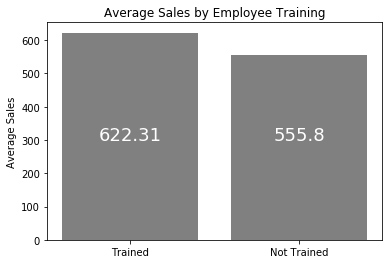

In [275]:
X = ['Trained', 'Not Trained']
y = [trained_emp.mean(),
     nontrained_emp.mean()]
plt.bar(X,y, color=('grey'))
plt.text(s=round(y[1],2), x=1, y=300, color="w", horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=300, color="w", horizontalalignment='center',size=18)
plt.ylabel('Average Sales')
plt.title('Average Sales by Employee Training')


##### HO:Sales training has no effect on employee performance
##### HA:Sales training has an effect on employee performance

In [266]:
stats.levene(trained_emp, nontrained_emp)

LeveneResult(statistic=2.3383995993425803, pvalue=0.1263660680458331)

with p value greater than .05 fail to reject the null. The two groups have equal variances.

In [267]:
# T test with equal variances
stats.ttest_ind(trained_emp, nontrained_emp, equal_var=True)

Ttest_indResult(statistic=1.591267404874491, pvalue=0.11169621459793783)

##### With p value greater than .05 we fail to reject the null. There is no sufficient evidence to conclude that sales training has an effect on employee performance.

# Does language have an effect on employee performance?

##### HO:Language has no effect on employee performance
##### HA:Language  has an effect on employee performance

In [76]:
biling_emp= emp_invoices[emp_invoices.bilingual==1]
biling_emp=biling_emp['totalinv']
monoling_emp= emp_invoices[emp_invoices.bilingual==0]
monoling_emp=monoling_emp['totalinv']

In [271]:
biling_emp.mean()


572.96550064433

In [272]:
monoling_emp.mean()

595.4835467730239

In [269]:
# checking for equal variances
stats.levene(monoling_emp, biling_emp)

LeveneResult(statistic=0.3051923729563232, pvalue=0.5807027764690373)

with p value greater than .05 fail to reject the null. The two groups have equal variances.

In [270]:
# T test with equal variance
stats.ttest_ind(biling_emp, monoling_emp, equal_var=True)

Ttest_indResult(statistic=-0.5176330338990535, pvalue=0.6047675085201232)

##### With p value greater that .05 fail to reject the null.There is no sufficient evidence to conclude that language has an effect on employee performance. 